# SOLUTION CSCE 823 Assignment 1

Inspired by Submission for CSCE 823 2019 SU - HW 1 ; author =   Justin Merrick


CSCE 823 Assignment 1 
---

Starter Code

Simple perceptron learning for NOT, OR, AND, and paper example (NUT).  Also trained on XOR which is
mainly a teaching tool to show how non-linearly separable points cannot be trained to with one layer.

Student will need to **analyze results and discuss** NOT, OR, AND and  NUT performance


Student will need to analyze results and discuss performance of single layer perceptron XOR

Student will need to build new multi layer perceptron for XOR, train, evaluate, and discuss performance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from sklearn.preprocessing import LabelEncoder

# import keras as keras

In [3]:
print("Tensor_Flow version:")
print(tf.__version__)

Tensor_Flow version:
2.6.0


In [4]:
print("Keras version:")
print(keras.__version__)

Keras version:
2.6.0


## Confirm tensorflow working properly
This will report on the GPUs available to tensorflow

In [5]:
print("Tensorflow version: ", tf.__version__)
print("Tensorflow devices: ", tf.config.list_physical_devices("GPU"))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))

Tensorflow version:  2.6.0
Tensorflow devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Enable GPU growth to solve cublas problem

(see https://stackoverflow.com/questions/41117740/tensorflow-crashes-with-cublas-status-alloc-failed)

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Test Tensorflow to ensure it is ready to train a model on GPU

(runs 2 epochs of a CNN on cifar10... not necessary for this HW but helpful code to ensure trainability of CNN on GPU)

In [7]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='Adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

history = model.fit(train_images, train_labels, batch_size=10, epochs=2)

Epoch 1/2
5000/5000 [==============================] - 13s 2ms/step - loss: 1.4433
Epoch 2/2
5000/5000 [==============================] - 11s 2ms/step - loss: 1.1681


# Step 0: Tools & Helper Functions

In [8]:
def makeDecisionBoundaryBool2(model,featureData,labelData,title):
    '''Build decision boundary figrue for 2-input, 1-output boolean logic functions
    Note that this assumes a hard sigmoid was used and establishes a cutoff at 0.5
    for predicting 0 or 1'''  
    cutoff = 0.5   #0.5 for Sigmoid. 0.0 for TANH
    fig, ax = plt.subplots()

    xmin,xmax = np.min(featureData[:,0])-0.1, np.max(featureData[:,0])+0.1
    ymin,ymax = np.min(featureData[:,1])-0.1, np.max(featureData[:,1])+0.1
    
    #Create filled countour map to color both sides of the boundary
    x = np.linspace(xmin,xmax,200)
    y = np.linspace(ymin,ymax,200)
    X, Y = np.meshgrid(x, y)
    grid = np.c_[X.ravel(),Y.ravel()]
    preds = model.predict(grid)  #get predictions
    z = preds.reshape(X.shape)>cutoff   # cutoff on predictions to return boolean output
    plt.contourf(X,Y,z,cmap='YlOrBr')
    
    #add annotated points to show where the boolean inputs lie on the graph
    ax.scatter(featureData[:,0],featureData[:,1], color='b', alpha = 0.5)
    for i, txt in enumerate(labelData):
        # ax.annotate(np.asscalar(txt), (featureData[i,0],featureData[i,1])) 
        ax.annotate(txt.item(), (featureData[i,0],featureData[i,1])) 
    
    #adjust the axis & add labels for the graph
    plt.axis([xmin, xmax, ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title(title)  

def graphHistory(history, title):
    '''Function for graphing the training and valiedation accuracy and loss'''
    # summarize history for accuracy
    fig = plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy ' + title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Tr. Acc', 'Val. Acc'])
    plt.show()

    # summarize history for loss
    fig = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss ' + title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Tr. Loss', 'Val. Loss'])
    plt.show()
    

# Step 1: Generic Keras model for perceptron (must be parameterized on call)

In [9]:
def perceptron(width, learningRate):
    '''Builds and returns a perceptron model of arbitrary input width & learning rate'''
    model = Sequential()  #define the building mode - sequential
    # declare the hidden layer with 1 node, hard sigmoid
    # set bias vector to all 1s
    model.add(Dense(units=1, activation='hard_sigmoid', 
                    use_bias=True, bias_initializer='ones', 
                    input_shape=(width,)))
    # declare the adam optimizer
    adam = optimizers.Adam(learning_rate=learningRate)
    # complile the model with loss = binary_crossentropy
    model.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Step 2:  Boolean Datasets

In [10]:
# Inputs to the perceptrons
xONE = np.array([[1],[0]])
xTWO = np.array([[0,0],[0,1],[1,0],[1,1]])
    
# y matrices for boolean output
yNOT = np.matrix('0;1')
yAND = np.matrix('0;0;0;1')
yOR = np.matrix('0;1;1;1')
yXOR = np.matrix('0;1;1;0')

# Step 3:  Instantiate Fyfe's Nut Dataset

In [11]:
# Defining NUT database arrays
xNUT = np.array([[2.2,1.4],[1.5,1.0],[0.6,0.5],[2.3,2.0],[1.3,1.5],[0.3,1.0]])
yNUT = np.array([[0],[0],[0],[1],[1],[1]])

# Step 4:  Modeling the Boolean NOT Dataset

## Step 4a:  Fit model on NOT dataset

In [12]:
# Learning 'NOT'

pmNOT = perceptron(width=1,learningRate=0.1)
training_verbosity = 0 #set to 1 or 2 for more detaied training output, 0 for none

history = pmNOT.fit(x=xONE, y=yNOT, batch_size=1, epochs=40, verbose=training_verbosity, callbacks=None, 
                      validation_split=0.1, 
                      validation_data=(xONE,yNOT), shuffle=True, class_weight=None,sample_weight=None, initial_epoch=0)





## Step 4b:  Report Training and Validation Performance Results

1/1 - 0s - loss: 7.8030 - accuracy: 0.5000
[7.802956581115723, 0.5]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


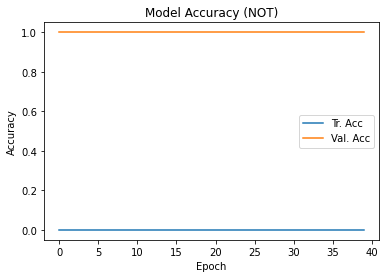

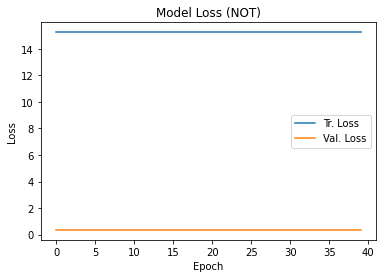

In [13]:
lossValMetrics = pmNOT.evaluate(xONE, yNOT, batch_size=2, verbose=2, sample_weight=None)
print(lossValMetrics)
#plot history
print(history.history.keys())    
graphHistory(history, '(NOT)')

One thing particularly striking in training the NOT dataset is that the final loss value is highly dependent upon initial state and is much less dependent on learning rate than expected. With a learning rate of 0.4 and a max epochs of 20, the loss changed drastically in subsequent runs, with the first yielding a loss near zero and an accuracy of 1.0 while the second yielded a loss near 8.0 and had only an accuracy of 0.5. Additionally, as the learning rate was decreased and the number of epochs increased, the same phenomenon was seen, though the magnitude of the loss was smaller. In this case, subsequent runs both saw accuracy of 1.0, but one had a near zero loss, while the other finished at 0.22. This distinction between model performance and model loss is important to recognize.

# Step 5: Modeling the  OR Dataset

## Step 5a:  Fit Model on OR

Note:  we are breaking the rule for train-val split of data since there are only 4 training points total

In [14]:
# Learning OR
pmOR = perceptron(width=2,learningRate=0.1)
training_verbosity = 1 #set to 1 or 2 for more detaied training output, 0 for none
history = pmOR.fit(x=xTWO, y=yOR, batch_size=1, epochs=50, verbose=training_verbosity, callbacks=None, 
    validation_split=0.0, validation_data=(xTWO,yOR), shuffle=True, class_weight=None, 
    sample_weight=None, initial_epoch=0)

Epoch 1/50
4/4 [==============================] - 0s 32ms/step - loss: 0.3899 - accuracy: 0.7500 - val_loss: 0.3508 - val_accuracy: 0.7500
Epoch 2/50
4/4 [==============================] - 0s 9ms/step - loss: 0.3441 - accuracy: 0.7500 - val_loss: 0.3246 - val_accuracy: 0.7500
Epoch 3/50
4/4 [==============================] - 0s 9ms/step - loss: 0.3186 - accuracy: 0.7500 - val_loss: 0.3081 - val_accuracy: 0.7500
Epoch 4/50
4/4 [==============================] - 0s 9ms/step - loss: 0.3001 - accuracy: 0.7500 - val_loss: 0.2919 - val_accuracy: 0.7500
Epoch 5/50
4/4 [==============================] - 0s 9ms/step - loss: 0.2869 - accuracy: 0.7500 - val_loss: 0.2735 - val_accuracy: 0.7500
Epoch 6/50
4/4 [==============================] - 0s 10ms/step - loss: 0.2678 - accuracy: 0.7500 - val_loss: 0.2579 - val_accuracy: 0.7500
Epoch 7/50
4/4 [==============================] - 0s 10ms/step - loss: 0.2524 - accuracy: 0.7500 - val_loss: 0.2411 - val_accuracy: 0.7500
Epoch 8/50
4/4 [===============

## Step 5b:  Evaluate training performance on OR

1/1 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
[0.0, 1.0]
[array([[5.3308163],
       [5.3959146]], dtype=float32), array([-2.5774593], dtype=float32)]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


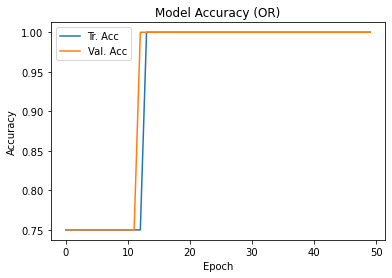

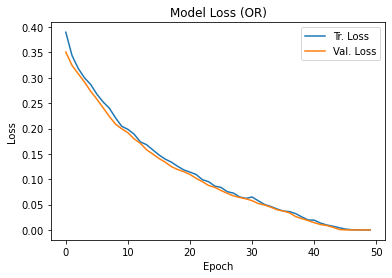

In [15]:
lossValMetrics = pmOR.evaluate(xTWO, yOR, batch_size=4, verbose=2, sample_weight=None)
print(lossValMetrics)
weights = pmOR.get_weights()
print(weights)
#plot history
print(history.history.keys())    
graphHistory(history, '(OR)')

In contrast with training a perceptron to solve NOT, training a perceptron to solve OR is more robust to the choice of initial weights, as long as the learning rate does not exceed 1.0 and the epochs do not drop below 10. While near zero loss was seen in as little as 4 epochs, high learning rates allowed the training to reach an accuracy of 1.0 with near zero loss typically between 5 and 9 epochs. As learning rate decreased, the chances of not reaching 1.0 accuracy in 10 epochs also decreased.

## Step 5c:  Display the Decision Boundary on OR

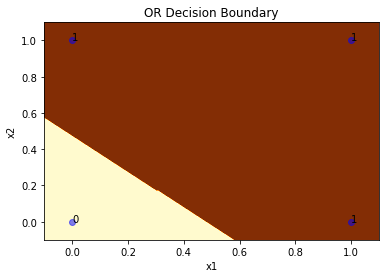

In [16]:
makeDecisionBoundaryBool2(pmOR,xTWO,yOR,'OR Decision Boundary')

The decision boundary found remained nearly identical regardless of learning rate (and provided the model reached 1.0 accuracy). Some change in slope was seen for particular random seeds.

# Step 6:  Modeling the AND Dataset

## Step 6a:  Fit model to AND Dataset

In [17]:
pmAND = perceptron(width=2,learningRate=0.6)
training_verbosity = 1 #set to 1 or 2 for more detaied training output, 0 for none
history = pmAND.fit(x=xTWO, y=yAND, batch_size=1, epochs=30, verbose=training_verbosity, callbacks=None, 
    validation_split=0.0, validation_data=(xTWO,yAND), shuffle=True, class_weight=None, 
    sample_weight=None, initial_epoch=0)

Epoch 1/30
4/4 [==============================] - 0s 31ms/step - loss: 1.5042 - accuracy: 0.0000e+00 - val_loss: 0.8226 - val_accuracy: 0.2500
Epoch 2/30
4/4 [==============================] - 0s 10ms/step - loss: 0.6841 - accuracy: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.7500
Epoch 3/30
4/4 [==============================] - 0s 9ms/step - loss: 4.0127 - accuracy: 0.7500 - val_loss: 3.8717 - val_accuracy: 0.7500
Epoch 4/30
4/4 [==============================] - 0s 12ms/step - loss: 3.8562 - accuracy: 0.7500 - val_loss: 3.8562 - val_accuracy: 0.7500
Epoch 5/30
4/4 [==============================] - 0s 10ms/step - loss: 3.8562 - accuracy: 0.7500 - val_loss: 3.8562 - val_accuracy: 0.7500
Epoch 6/30
4/4 [==============================] - 0s 12ms/step - loss: 3.8562 - accuracy: 0.7500 - val_loss: 3.8562 - val_accuracy: 0.7500
Epoch 7/30
4/4 [==============================] - 0s 9ms/step - loss: 3.8562 - accuracy: 0.7500 - val_loss: 3.8562 - val_accuracy: 0.7500
Epoch 8/30
4/4 [=========

## Step 6b:  Evaluate Training Performance on AND Dataset

1/1 - 0s - loss: 3.8562 - accuracy: 0.7500
[3.8562371730804443, 0.75]
[array([[-1.5591062],
       [-2.134958 ]], dtype=float32), array([-5.0190563], dtype=float32)]


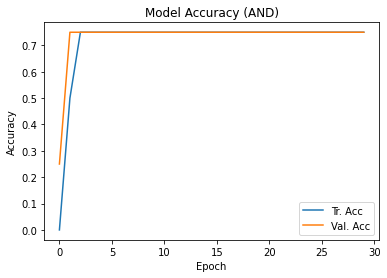

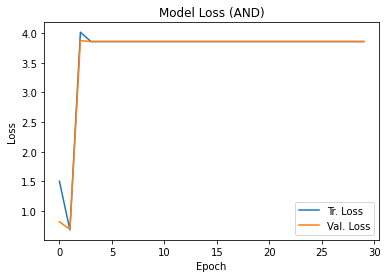

In [18]:
lossValMetrics = pmAND.evaluate(xTWO, yAND, batch_size=4, verbose=2, sample_weight=None)
print(lossValMetrics)
weights = pmAND.get_weights()
print(weights)
graphHistory(history, '(AND)')

The AND dataset lies somewhere between NOT and OR on its sensitivity to initial conditions. High learning rates are acceptable but fail more often than with OR. Regardless of learning rate, with enough epochs 1.0 accuracy was achieved.

## Step 6c:  Display Decision Boundary of AND Dataset

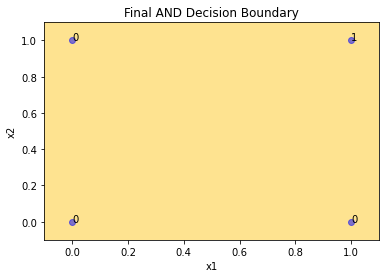

In [19]:
makeDecisionBoundaryBool2(pmAND,xTWO,yAND,'Final AND Decision Boundary')

The decision boundary appears similar to the OR decision boundary in slope and its behavior to initial conditions, but encloses the opposite corner of the solution space, as expected.

# Step 7:  Modeling Fyfe's NUT dataset

## Step 7a:  Fit a perceptron model to the NUT dataset

In [20]:
# Final learning scenario -- NUT
#batchSize, width, learningRate
pmNUT = perceptron(width=2,learningRate=0.2)
training_verbosity = 1 #set to 1 or 2 for more detaied training output, 0 for none
history = pmNUT.fit(x=xNUT, y=yNUT, batch_size=1, epochs=50, verbose=training_verbosity, callbacks=None, 
    validation_split=0.0, validation_data=(xNUT,yNUT), shuffle=True, class_weight=None, 
    sample_weight=None, initial_epoch=0)

Epoch 1/50
6/6 [==============================] - 0s 23ms/step - loss: 1.0741 - accuracy: 0.3333 - val_loss: 0.8337 - val_accuracy: 0.5000
Epoch 2/50
6/6 [==============================] - 0s 8ms/step - loss: 0.8633 - accuracy: 0.5000 - val_loss: 0.7226 - val_accuracy: 0.5000
Epoch 3/50
6/6 [==============================] - 0s 8ms/step - loss: 0.7578 - accuracy: 0.5000 - val_loss: 0.7022 - val_accuracy: 0.6667
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 0.7299 - accuracy: 0.5000 - val_loss: 0.6791 - val_accuracy: 0.5000
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 0.6977 - accuracy: 0.3333 - val_loss: 0.6650 - val_accuracy: 0.5000
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 0.7552 - accuracy: 0.1667 - val_loss: 0.6617 - val_accuracy: 0.5000
Epoch 7/50
6/6 [==============================] - 0s 8ms/step - loss: 0.6673 - accuracy: 0.6667 - val_loss: 0.6305 - val_accuracy: 0.6667
Epoch 8/50
6/6 [=================

In [21]:
## Step 7b:  Evaluate model performance on the NUT dataset

1/1 - 0s - loss: 0.1309 - accuracy: 1.0000
[0.13090050220489502, 1.0]
[array([[-3.5480366],
       [ 6.220371 ]], dtype=float32), array([-2.6972709], dtype=float32)]


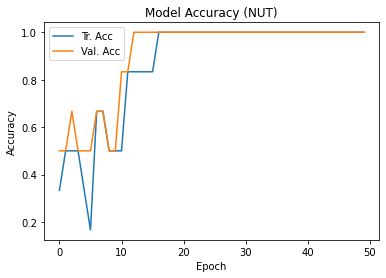

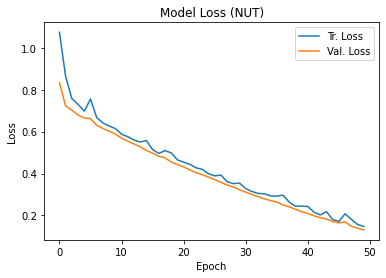

In [22]:
lossValMetrics = pmNUT.evaluate(xNUT, yNUT, batch_size=6, verbose=2, sample_weight=None)
print(lossValMetrics)
print(pmNUT.get_weights())
graphHistory(history, '(NUT)')

## Step 7c:  Plot decision boundary on NUT dataset

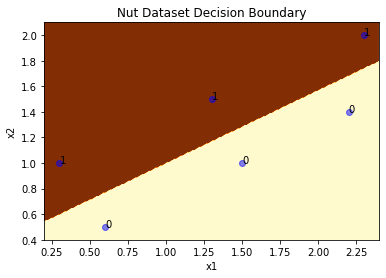

In [23]:
makeDecisionBoundaryBool2(pmNUT,xNUT,yNUT,'Nut Dataset Decision Boundary')

The Nut dataset has a smaller maximum margin between classes and more datapoints. This makes it unsuitable to higher learning rates, with rates of 0.4 or higher failing to achieve 1.0 accuracy at least 33% of the time. However, on lower learning rates and a small amount of epochs (50), the perceptron is repeatably able to achieve 1.0 accuracy and a decision boundary that is very similar across initial seeds.

# Step 8: Modeling XOR logic with a single perceptron

## Step 8a:  Fit a single perceptron to the XOR data

In [24]:
# This will not perform well due to the classes are not linearly seperable
print("Starting XOR training")
#batchSize, width, learningRate
pm_single_layerXOR = perceptron(width=2,learningRate=.1)
training_verbosity = 1 #set to 1 or 2 for more detaied training output, 0 for none
history = pm_single_layerXOR.fit(x=xTWO, y=yXOR, batch_size=1, epochs=200, verbose=training_verbosity, callbacks=None, 
    validation_split=0.0, validation_data=(xTWO,yXOR), shuffle=True, class_weight=None, 
    sample_weight=None, initial_epoch=0)
print("Completed XOR training")

Starting XOR training
Epoch 1/200
4/4 [==============================] - 0s 33ms/step - loss: 4.1780 - accuracy: 0.5000 - val_loss: 4.1390 - val_accuracy: 0.5000
Epoch 2/200
4/4 [==============================] - 0s 9ms/step - loss: 4.1397 - accuracy: 0.5000 - val_loss: 4.1166 - val_accuracy: 0.5000
Epoch 3/200
4/4 [==============================] - 0s 10ms/step - loss: 4.1107 - accuracy: 0.5000 - val_loss: 4.0971 - val_accuracy: 0.5000
Epoch 4/200
4/4 [==============================] - 0s 9ms/step - loss: 4.0919 - accuracy: 0.5000 - val_loss: 4.0819 - val_accuracy: 0.5000
Epoch 5/200
4/4 [==============================] - 0s 10ms/step - loss: 4.0815 - accuracy: 0.5000 - val_loss: 4.0614 - val_accuracy: 0.5000
Epoch 6/200
4/4 [==============================] - 0s 9ms/step - loss: 4.0607 - accuracy: 0.5000 - val_loss: 4.0436 - val_accuracy: 0.5000
Epoch 7/200
4/4 [==============================] - 0s 11ms/step - loss: 4.0436 - accuracy: 0.5000 - val_loss: 4.0284 - val_accuracy: 0.5000
E

## Step 8b:  Evaluate single perceptron model performance on the XOR data

1/1 - 0s - loss: 3.8123 - accuracy: 0.7500
[3.812309503555298, 0.75]
[array([[5.4500933],
       [5.3242345]], dtype=float32), array([-2.6575263], dtype=float32)]


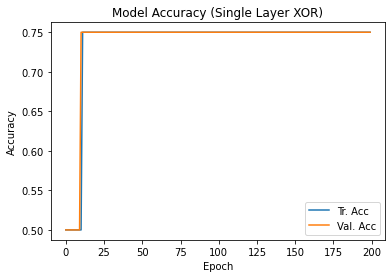

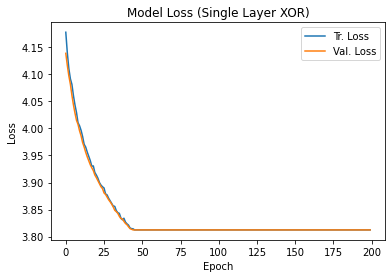

In [25]:
lossValMetrics = pm_single_layerXOR.evaluate(xTWO, yXOR, batch_size=4, verbose=2, sample_weight=None)
print(lossValMetrics)
print(pm_single_layerXOR.get_weights())
graphHistory(history, '(Single Layer XOR)')

## Step 8c:  Decision Boundary for XOR using single perceptron

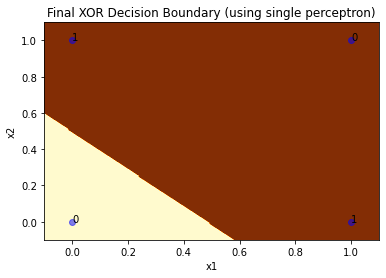

In [26]:
makeDecisionBoundaryBool2(pm_single_layerXOR,xTWO,yXOR,'Final XOR Decision Boundary (using single perceptron)')

# Step 9:  Modeling XOR with a Multilayer Perceptron

## Step 9a:  Define your multilayer models in Keras

{TODO: discussion of how you built the model & selected ranges of parameter choices}

In [27]:
#TODO - insert student code here
# your model should be called "pm_multi_layerXOR"
def pm_multi_layerXOR(**kwargs):
    model = Sequential()
    num_hidden_layers = kwargs.pop("num_hidden_layers")
    lr = kwargs.pop("lr")
    for _ in range(num_hidden_layers):
        model.add(Dense(use_bias=True, bias_initializer='ones', input_shape=(2,), **kwargs))
    model.add(Dense(units=1, activation='hard_sigmoid', use_bias=True, bias_initializer='ones', 
                    input_shape=(2,)))
    
    optimizer = optimizers.Adam(learning_rate=lr)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
    
 

## Step 9b:  Fit the models on the XOR dataset

Note that the student used an experimental design (factors and levels) to explore the space of hyperparameters
An abridged version of the experimenter is used below when ```SMALLSET``` is ```True```.  Set ```SMALLSET``` to ```FALSE``` to run the
entire suite of experiments (not recommended if you dont have a good GPU... may take over an hour)

In [28]:
class Experimenter():
    def __init__(self):
        SMALLSET = True
        if SMALLSET:  #smaller set of experiments from the best the student found
            self.hidden_layer_vals = [1,2]
            self.hidden_size_vals = [2]
            self.activation_choices = ['relu', 'sigmoid', 'hard_sigmoid']
            self.learning_rates = [0.1]
            self.experiment_num = 0
            self.create_experiment_list()
            self.num = self.experiment_list.shape[0]
           
        else:  #run the full set of experiments the student tried... may take more than 1 hour
            self.hidden_layer_vals = list(range(1,4))
            self.hidden_size_vals = list(range(1,4))
            self.activation_choices = ['relu', 'sigmoid', 'hard_sigmoid']
            self.learning_rates = [1e-3, 1e-2, 1e-1, 0.2, 0.4]
            self.experiment_num = 0
            self.create_experiment_list()
            self.num = self.experiment_list.shape[0]
    
    def create_experiment_list(self):
        self.experiment_list = np.meshgrid(self.hidden_layer_vals, self.learning_rates, 
                                           self.hidden_size_vals, self.activation_choices)
        self.experiment_list = np.array(self.experiment_list).T.reshape([-1,4])
        
    def get_experiment(self):
        try:
            next_experiment = self.experiment_list[self.experiment_num,:]
        except IndexError:
            print("End of experiment list")
        self.experiment_num += 1
        
        experiment_dict = {'num_hidden_layers': int(next_experiment[0]),
                          'lr': float(next_experiment[1]),
                          'units': int(next_experiment[2]),
                          'activation': next_experiment[3]
                          }
        
        return experiment_dict
        
        

In [29]:
class TerminateOnBaseline(callbacks.Callback):
    """Callback that terminates training when either acc or val_acc reaches a specified baseline
    """
    def __init__(self, monitor='acc', baseline=0.9):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True

In [30]:
#TODO - insert student code here
experimenter = Experimenter()
callback = [TerminateOnBaseline(monitor='acc', baseline=0.8)]

histories = []
models = []
tot_exp_count = experimenter.num
for exp_counter in range(experimenter.num):
    experiment = experimenter.get_experiment()
    print("Running experiment number ", exp_counter+1, " of ", tot_exp_count, " Conditions: ", experiment )
    model = pm_multi_layerXOR(**experiment)
    history = model.fit(x=xTWO, y=yXOR, batch_size=1, epochs=150, verbose=0, callbacks=callback, 
                        validation_split=0, validation_data=(xTWO,yXOR), shuffle=True, class_weight=None, 
                        sample_weight=None, initial_epoch=0)
    histories.append(history)
    models.append(model)

Running experiment number  1  of  6  Conditions:  {'num_hidden_layers': 1, 'lr': 0.1, 'units': 2, 'activation': 'relu'}
Running experiment number  2  of  6  Conditions:  {'num_hidden_layers': 2, 'lr': 0.1, 'units': 2, 'activation': 'relu'}
Running experiment number  3  of  6  Conditions:  {'num_hidden_layers': 1, 'lr': 0.1, 'units': 2, 'activation': 'sigmoid'}
Running experiment number  4  of  6  Conditions:  {'num_hidden_layers': 2, 'lr': 0.1, 'units': 2, 'activation': 'sigmoid'}
Running experiment number  5  of  6  Conditions:  {'num_hidden_layers': 1, 'lr': 0.1, 'units': 2, 'activation': 'hard_sigmoid'}
Running experiment number  6  of  6  Conditions:  {'num_hidden_layers': 2, 'lr': 0.1, 'units': 2, 'activation': 'hard_sigmoid'}


## Step 9c:  Report the performances of the multilayer models on XOR

In [31]:
print([len(history.history['accuracy']) for history in histories])

[150, 150, 150, 150, 150, 150]


In [32]:
successful_run_mask = [True if max(history.history['val_accuracy'])>0.75 else False for history in histories]
successful_histories = [history for history in histories if max(history.history['val_accuracy'])>0.75]
successful_experiments = experimenter.experiment_list[successful_run_mask,:]
print('Successful Runs: {success:3d} out of {total:3d} ({percent:3.2f}%)'.format(success=sum(successful_run_mask), total=experimenter.num, percent=sum(successful_run_mask)/experimenter.num*100))

act_encoder = LabelEncoder()
act_encoder.fit(experimenter.activation_choices);

successful_experiments[:,-1] = act_encoder.transform(successful_experiments[:,-1])
successful_experiments = successful_experiments.astype(float)

Successful Runs:   2 out of   6 (33.33%)


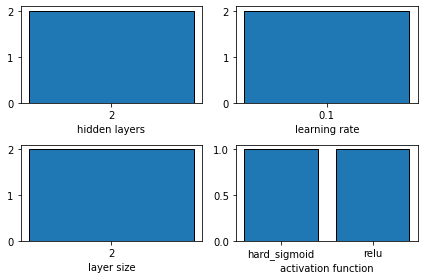

In [33]:
fig, axs = plt.subplots(2, 2)
axs = np.reshape(axs, (4,-1)).squeeze()
labels = ['hidden layers','learning rate','layer size','activation function']
widths = [0.8,0.05,0.8,0.8]
for ax, experiment_param, label, width in zip(axs,successful_experiments.T, labels, widths):
    bins, counts = np.unique(experiment_param, return_counts=True)
    ax.bar(bins, counts, width=width, edgecolor='k')
    ax.set_xlabel(label)
    ax.set_xticks(np.unique(experiment_param))
    if label=='activation function':
        ax.set_xticklabels(act_encoder.inverse_transform(np.unique(experiment_param).astype(int)))
plt.tight_layout()
plt.show();

In [34]:
epochs_used = [len(history.history['accuracy']) for history in successful_histories]
final_loss = [history.history['val_loss'][-1] for history in successful_histories]

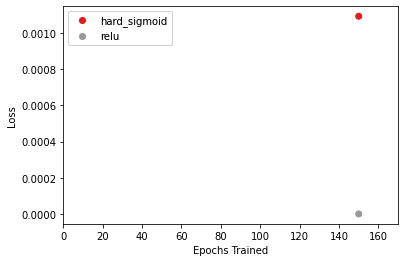

In [35]:
fig,ax = plt.subplots()
# scatter = ax.scatter(epochs_used, final_loss, c=successful_experiments[:,-1], label=colors, cmap='Set1')
scatter = ax.scatter(epochs_used, final_loss, c=successful_experiments[:,-1], cmap='Set1')
leg_ele = scatter.legend_elements()
leg_ele = (leg_ele[0], act_encoder.classes_)
legend1 = ax.legend(*leg_ele)
ax.add_artist(legend1)
ax.set_xlim(0,170)
ax.set_xlabel('Epochs Trained')
ax.set_ylabel('Loss')
plt.show;

In [36]:
min_losses = [min(history.history['val_loss']) for history in successful_histories]
min_loss = min(min_losses)
best_mask = [True if min(history.history['val_loss'])==min_loss else False for history in histories]
best_index = best_mask.index(True)
best_model = models[best_index]
best_history = histories[best_index]
best_experiment = experimenter.experiment_list[best_index]

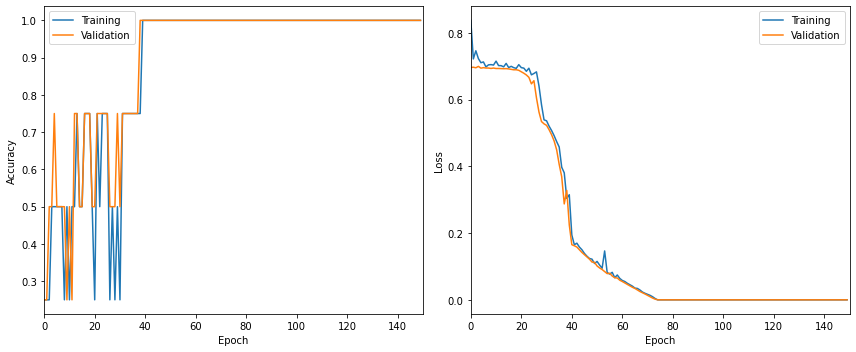

In [37]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].plot(best_history.history['accuracy'], label='Training')
axs[0].plot(best_history.history['val_accuracy'], label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_xlim([0, 150])
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(best_history.history['loss'], label='Training')
axs[1].plot(best_history.history['val_loss'], label='Validation')
axs[1].set_xlabel('Epoch')
axs[1].set_xlim([0, 150])
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show();

In [38]:
#TODO - insert Student code here
best_eval = best_model.evaluate(x=xTWO, y=yXOR, batch_size=4, verbose=0)
best_weights = best_model.get_weights()
print('# of hidden layers: ',best_experiment[0])
print('learning rate: ', best_experiment[1])
print('hidden layer width: ', best_experiment[2])
print('activation function: ', best_experiment[3])
for i in range(int(best_experiment[0])):
    print('Layer {} weights: '.format(i), best_weights[2*i])
    print('Layer {} bias: '.format(i), best_weights[2*i+1])
print('Final layer weights: ',best_weights[-2])
print('Final layer bias: ', best_weights[-1])

# of hidden layers:  2
learning rate:  0.1
hidden layer width:  2
activation function:  relu
Layer 0 weights:  [[ 3.2600577 -1.7477503]
 [-1.6066171  3.0377872]]
Layer 0 bias:  [1.229056  2.2045302]
Layer 1 weights:  [[ 2.1879165  2.403859 ]
 [-4.057821  -0.435092 ]]
Layer 1 bias:  [-0.2234653  2.2611787]
Final layer weights:  [[ 3.1735268]
 [-1.234759 ]]
Final layer bias:  [2.6156623]


A grid search was performed over various values for the number of hidden layers, the learning rate, the width of the hidden layers, and the activation function. A custom version of Early Stopping terminated the training when an accuracy of 1.0 was obtained. Only 13% of the experiments were successful in obtaining this accuracy within 150 epochs. The parameters that favored success were a learning rate of 0.1 and 1 hidden layer, though 3 hidden layers was moderately successful. Little difference existed in the activation function of the hidden layers or the width of the hidden layers except that widths of 1 were unsuccessful, as expected. The scatterplot above shows the loss and the epochs trained for each of the successful cases. This plot also shows that no activation function was consistently converging to accuracy 1.0 faster than any other activation functin. The lowest loss occurred as shown above, with 1 hidden layer, a learning rate of 0.1, a hidden layer width of 2, and a sigmoid activation function. 

## Step 9d:  Plot the decision boundary for the best multilayer perceptron on XOR

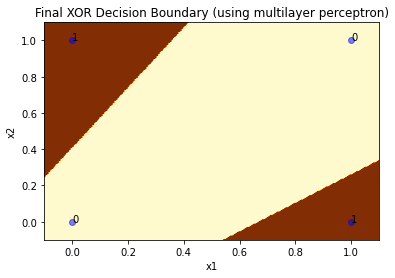

In [39]:
#uncomment the following line after you build & train your model
makeDecisionBoundaryBool2(best_model,xTWO,yXOR,'Final XOR Decision Boundary (using multilayer perceptron)')

Depending on the initialization of the network, the decision boundary could be different when this is run multiple times.

The decision boundary discovered here could be the very different each time. 

For example, the region for an output of one is defined by two lines with an approximate slope of -1. In the in-class exercise, the decision boundary was flipped, with two lines defining the region for an output of zero, each with an approximate slope of 1. The weights shown for the lowest loss model above are significantly larger than those found using heaviside activation and also differ in sign. It is this difference in sign rather than the difference in value which contributes to the orientation of the decision boundary. The relative value of the weights determine the slope of the lines defining the decision boundary and the relative value of the bias then determine the intercept of the lines defining the decision boundary.